In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE


%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#get directory
df_train_path = os.path.join('/content/drive/MyDrive/data','df_train_scaled.csv')
df_test_path = os.path.join('/content/drive/MyDrive/data','df_test_scaled.csv')

#download in chunks
df_train = pd.read_csv(df_train_path,compression='zip', index_col=0)
df_test = pd.read_csv(df_test_path,compression='zip', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_train.shape,df_test.shape

((1073090, 21), (194208, 21))

In [5]:
df_train.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.608872,0.164693,-0.163457,-0.325463,1.122052,0.447071,-0.429185,-1.307963,0,-0.284092,-1.473992,0,-0.546784,-1.023435,-0.312566,0,-0.507738,0.163442,-1.289327,-0.664438,0.751798
67,1.642269,1.571844,-1.681827,-1.852288,-1.097898,2.003534,0.922524,-1.307963,1,-1.129831,0.315839,0,0.051569,1.656392,0.185487,0,1.811497,-0.290346,0.013519,-1.142713,-0.953725
109,-0.608872,0.164693,-0.163457,-0.325463,-1.097898,-1.109391,0.373296,1.107810,0,-0.284092,0.504437,0,-0.039984,1.171393,-0.810619,0,-0.405765,-0.661155,-1.119129,-0.505013,0.751305
166,-0.608872,0.045809,-0.163457,-0.172780,-1.375392,-1.109391,-1.966736,1.107810,0,-0.284092,1.057904,0,-0.491274,-0.982334,-0.810619,0,-1.030678,0.453866,-0.581365,0.451536,0.690353
240,-0.608872,0.350584,-0.163457,-0.478145,-1.097898,-1.109391,-0.044315,1.107810,0,-0.706962,1.628628,0,-0.101400,0.123301,-0.810619,0,0.015201,-0.203410,-1.206653,-0.823863,0.847883


In [6]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

#test variables
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [7]:
X_train.shape,X_test.shape

((1073090, 13), (194208, 13))

In [8]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    'xgb__eta': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 12],
    'xgb__colsample_bytree': [0.9, 1.0],
    }
#define the pipeline
model_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(n_estimators=200,
                              n_jobs=-1, scale_pos_weight=estimate))
])
#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=3, 
                   verbose=50, 
                   scoring='roc_auc')
#fit to training data
clf.fit(X_train, y_train)

Estimate: 3.973
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   3 out of  54 | elapsed:  5.0min remaining: 84.6min
[Parallel(n_jobs=-1)]: Done   5 out of  54 | elapsed:  5.1min remaining: 49.7min
[Parallel(n_jobs=-1)]: Done   7 out of  54 | elapsed:  5.2min remaining: 35.2min
[Parallel(n_jobs=-1)]: Done   9 out of  54 | elapsed:  5.3min remaining: 26.7min
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:  5.8min remaining: 22.7min
[Parallel(n_jobs=-1)]: Done  13 out of  54 | elapsed:  5.9min remaining: 18.5min
[Parallel(n_jobs=-1)]: Done  15 out of  54 | elapsed:  5.9min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done  17 out of  54 | elapsed: 10.8min remaining: 23.6min
[Parallel(n_jobs=-1)]: Done  19 out of  54 | elapsed: 11.7min remaining: 21.6min
[Parallel(n_jobs=-1)]: Done  21 out of  54 | elapsed: 1

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                                                      n_estimators=200,
                  

In [9]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.05, 'xgb__max_depth': 3}
Best model score: 

0.7154332017625974


In [10]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[90182, 50348],
       [18586, 35092]])

In [11]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(X_test)[:,1],
                                 pos_label=1)

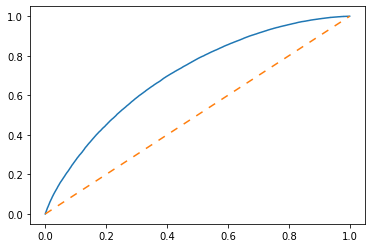

AUC: 0.704


In [12]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

# calculate AUC
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('AUC: %.3f' % auc)

In [13]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.5044925890251442

              precision    recall  f1-score   support

           0       0.83      0.64      0.72    140530
           1       0.41      0.65      0.50     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.65      0.61    194208
weighted avg       0.71      0.65      0.66    194208



In [14]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Models/xgb_cv_final.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle,
                protocol=3)

Saving model at: /content/drive/MyDrive/Models/xgb_cv_final.pkl
